In [1]:
# explore.ipynb

# NOTE: This will not be able to be ran because it depends on other python files, but if you look at the github you can see what those files are. https://github.com/aidangillespie52/CSC4260-Project

In [13]:
import torch
import os
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from scipy.stats import zscore
import cv2

In [3]:
# Grab local imports
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_root, "src"))

from data.load_data import get_train_dataset

In [4]:
train_dataset = get_train_dataset()
dataloader = DataLoader(train_dataset)

# Data Cleaning

In [11]:
img_data_path = "../data/image_data"
box_train_path = "../data/bbox_train.csv"

# Load annotations
annotations = pd.read_csv(box_train_path)

# Get list of images from the CSV
csv_images = set(annotations['Name'])  # Adjust column name if necessary

# Get list of images from the image_data directory
fs_images = set(os.listdir(img_data_path))

# Find images in image_data that are missing from the CSV
missing_from_csv = fs_images - csv_images
print('Images not in training', len(missing_from_csv))

Images not in training 2463


## They didn't split up the images into a test and train folder which isn't a big deal, but we just have to keep in mind when we're reading in data

In [ ]:
all_labels = np.array([int(x) for _, x in dataloader])

# Exploratory Analysis

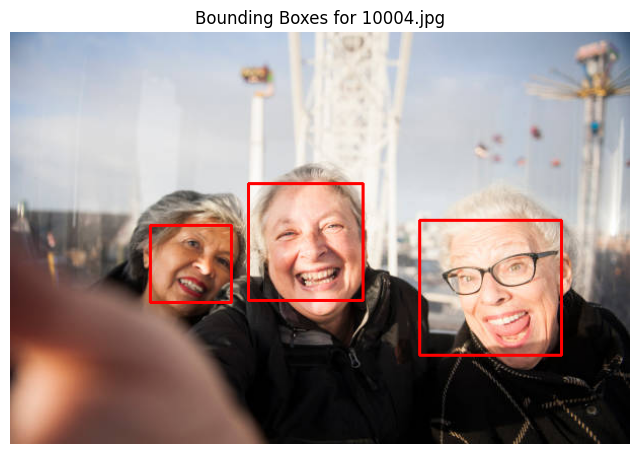

In [16]:
def display_image_with_boxes(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image {image_name} not found.")
    else:
        # Convert BGR to RGB (Matplotlib expects RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get bounding boxes for this image
        img_annotations = annotations[annotations['Name'] == image_name]

        # Draw bounding boxes
        for _, row in img_annotations.iterrows():
            xmin, ymin, xmax, ymax = row[['xmin', 'ymin', 'xmax', 'ymax']]
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

        # Display the image
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Bounding Boxes for {image_name}")
        plt.show()

image_name = annotations.iloc[10]['Name']
image_path = os.path.join(img_data_path, image_name)
display_image_with_boxes(image_path)

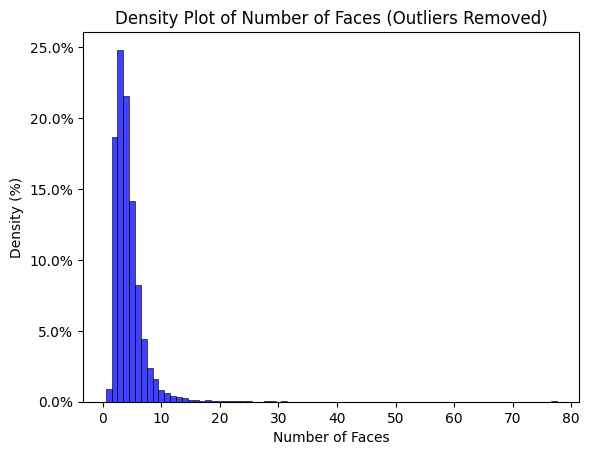

Average Number of Faces per Image: 4.28


In [ ]:
sns.histplot(
    all_labels, 
    bins=range(min(all_labels), max(all_labels) + 1), 
    color='blue', 
    discrete=True, 
    stat='probability'  # Normalize to show density as percentages
)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.1f}%'))

plt.xlabel('Number of Faces')
plt.ylabel('Density (%)')
plt.title('Density Plot of Number of Faces (Outliers Removed)')
plt.show()

print('Average Number of Faces per Image:', round(all_labels.mean(), 2))

## We need to watch out for the scenario where our models just predict 4 faces every time and get 25% accuracy

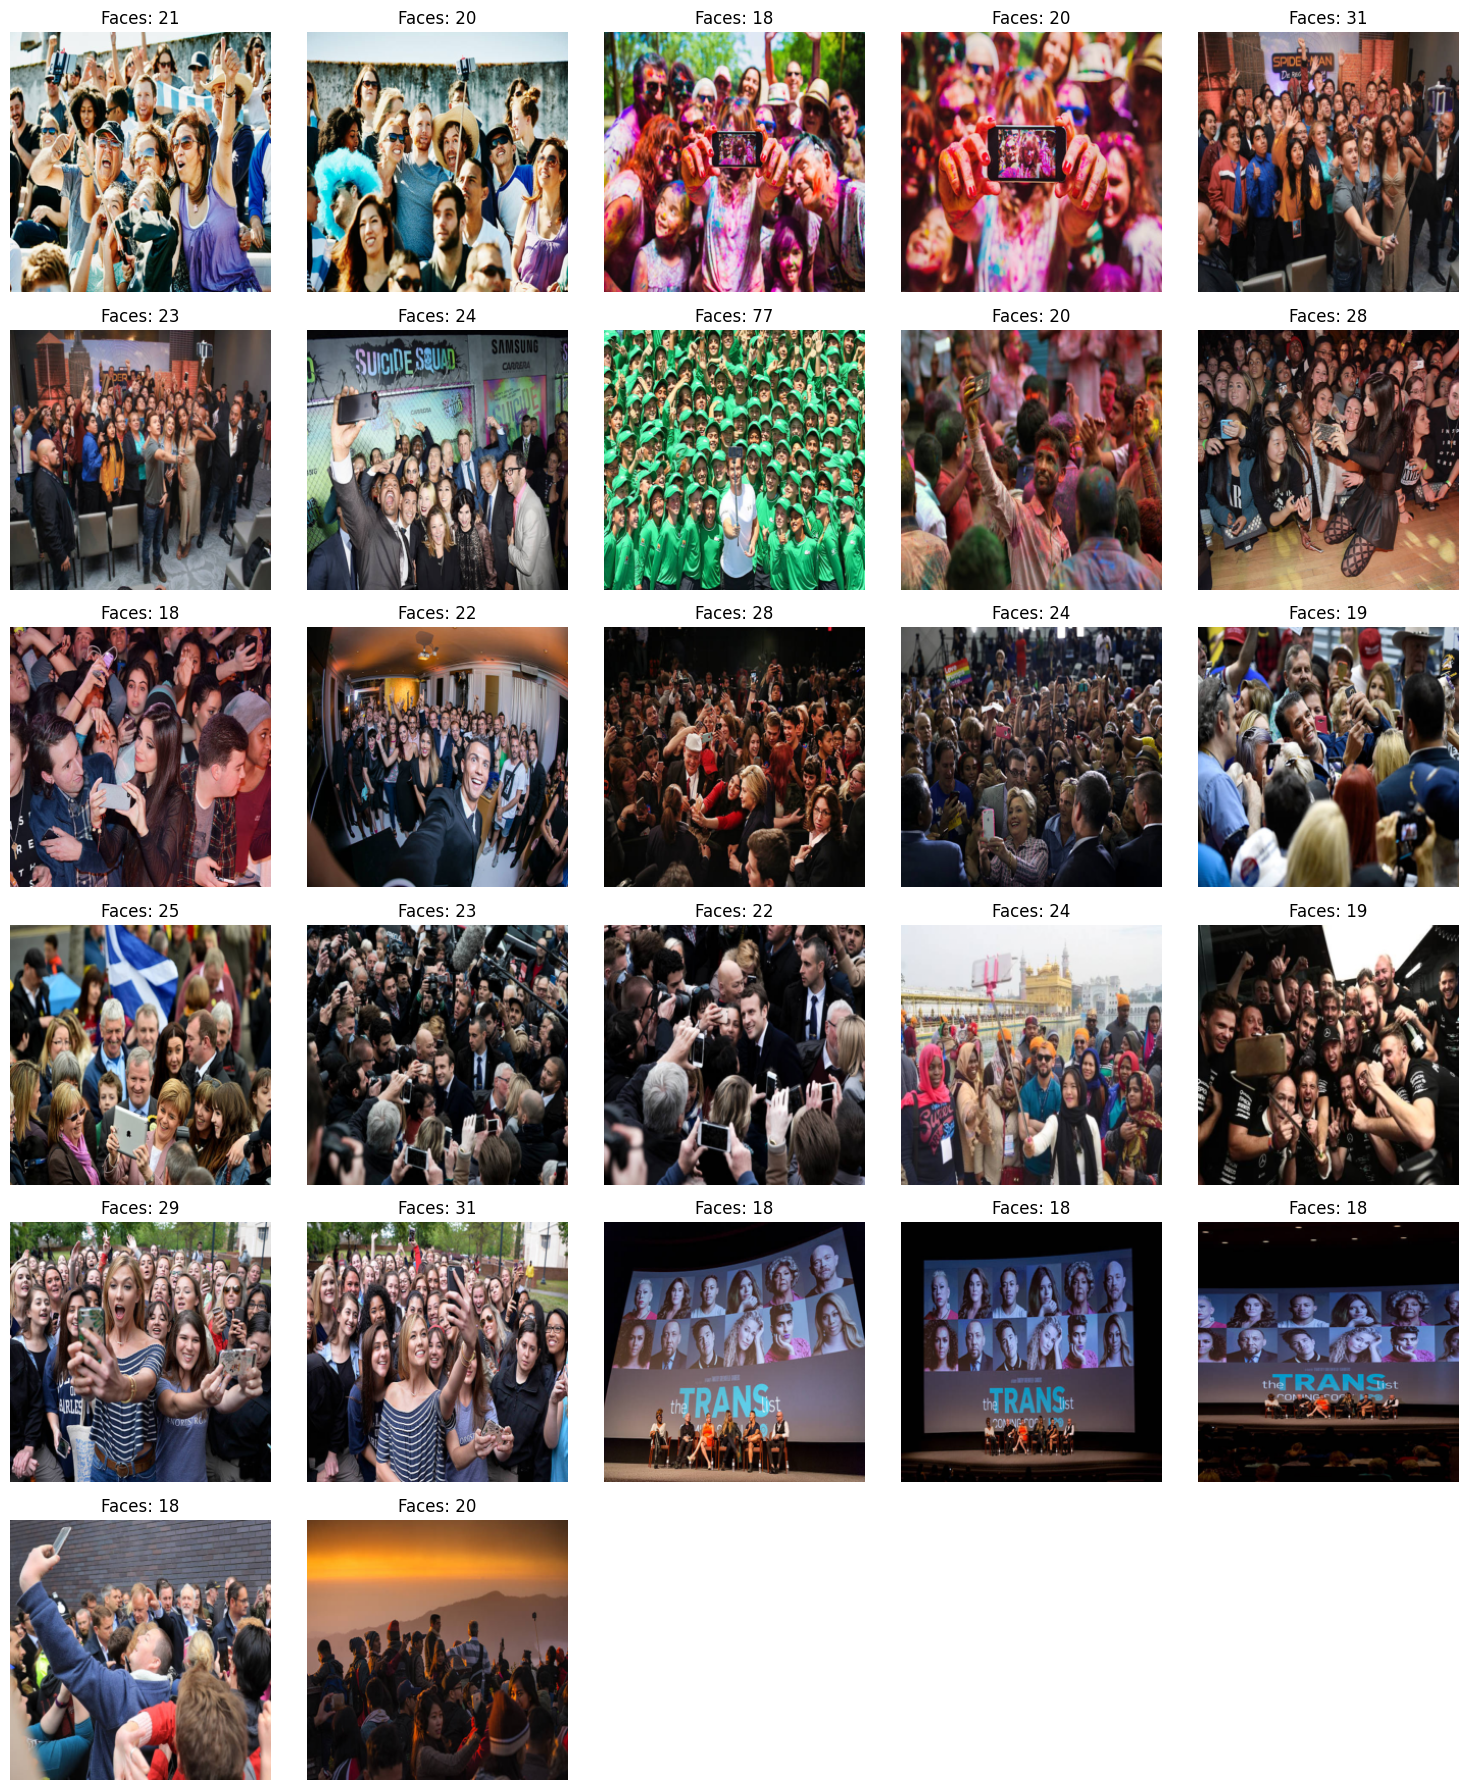

In [ ]:
def show_outliers(data, zscore_threshold=5):
    # Compute Z-scores for the dataset
    z_scores = zscore(data)

    z_score_data = list(enumerate(zip(z_scores, data)))

    top_zscore_with_faces = [
        (index, (z_score, num_faces)) for index, (z_score, num_faces) in z_score_data if z_score >= zscore_threshold
    ]

    top_num_faces = [int(top_label) for (_, (_, top_label)) in top_zscore_with_faces]

    top_images = []
    top_labels_filtered = []

    for image, label in dataloader:
        if int(label) in top_num_faces:
            top_images.append(image)
            top_labels_filtered.append(label)

    top_images = torch.stack(top_images) if isinstance(top_images[0], torch.Tensor) else top_images

    num_images = len(top_images)
    cols = 5
    rows = (num_images // cols) + (num_images % cols > 0)

    _, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

    axes = axes.flatten() if num_images > 1 else [axes]

    for i, (img, lbl) in enumerate(zip(top_images, top_labels_filtered)):
        img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Faces: {int(lbl)}")
        axes[i].axis('off')

    # Hide axes that don't need to show
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
show_outliers(all_labels)

## Best that we remove these images and any other images with large amounts of faces since this is around 0.3% of the dataset and could throw off the model if we're trying to generalize it so it could take in a normal amount of faces

## I also noticed that a majority of the pictures in the dataset show an image of a person taking a selfie. This isn't necessasrily a good or bad thing but just something I noticed